# Decision Tree Implementation from Scratch

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional imports if necessary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('bankAuth.txt',names=['variance','skewness','curtosis','entropy','label'])

In [28]:
df

,variance,skewness,curtosis,entropy,label
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error
4. Log Loss

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [48]:
# your code here
def giniIndex(labels):
    li = np.unique(labels)
    n= len(labels)
    d={}
    for i in labels:
        if i in d:
            d[i]+=1
        else:
            d[i]=1
    val=0
    for i in li:
        pi = d[i]/n
        val += pi*pi
    return 1-val

def entropy(labels):
    li = np.unique(labels)
    n= len(labels)
    d={}
    for i in labels:
        if i in d:
            d[i]+=1
        else:
            d[i]=1
    val=0
    for i in li:
        pi = d[i]/n
        val += (-pi)*(np.log2(pi))
    return val

def misclassification_error(labels):
    li = np.unique(labels)
    n= len(labels)
    d={}
    for i in labels:
        if i in d:
            d[i]+=1
        else:
            d[i]=1
    mini = float('inf')
    for k in d.keys():
        if d[k]<mini:
            mini=d[k]
    val = mini/n
    return val

def infoGain( parent, left, right, function="gini"):
    pl = len(left)/len(parent)
    pr = len(right)/len(parent)
    if function=="misclassification_error":
        gain = misclassification_error(parent) - (pl*misclassification_error(left) + pr*misclassification_error(right))
    elif function=="entropy":
        gain = entropy(parent) - (pl*giniIndex(left) + pr*entropy(right))
    else:
        gain = giniIndex(parent) - (pl*giniIndex(left) + pr*giniIndex(right))
    return gain

### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [49]:
# your code here
class TreeNode():
    
    def __init__(self,colIndex=None,threshold=None,left=None,right=None,gain=None,value=None):
        self.colIndex = colIndex
        self.gain = gain
        self.threshold = threshold
        self.left = left
        self.right = right
        # for leaf node
        self.value = value
        
class DecisionTree():
    
    def __init__(self,maxDepth=2,func="gini"):
        self.maxDepth=maxDepth
        self.root=None
        self.func=func
    
    def constructTree(self,dataset,depth):
        x = dataset[:,:-1]
        y=dataset[:,-1]
        
        rows,cols = np.shape(x)
        if depth<=self.maxDepth:
            tempData = self.leftRightSplit(rows,cols,dataset)
            if tempData['gain']>0:
                leftTree = self.constructTree(tempData['leftData'],depth+1)
                rightTree = self.constructTree(tempData['rightData'],depth+1)
                return TreeNode(tempData['colIndex'],tempData['threshold'],leftTree,rightTree,tempData['gain'])
        #leaf node
        li = list(y)
        return TreeNode(value=max(li,key=li.count))
    
    def splitData(self, dataset, feature_index, threshold):        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def leftRightSplit(self,rows,cols,dataset):
        d = {}
        maxGain = -float("inf")
        d["colIndex"] = -1
        d["gain"] = -1
        d["threshold"] = -1
        d["leftData"] = -1
        d["rightData"] = -1
        for col in range(cols):
            vals = dataset[:,col]
            thlist = np.unique(vals)
            
            for i in thlist:
                leftData, rightData = self.splitData(dataset,col,i)
                if len(leftData)>0 and len(rightData)>0:
                    y,ly,ry = dataset[:,-1], leftData[:,-1], rightData[:,-1]
                    currGain = infoGain(y,ly,ry,self.func)
                    
                    if currGain >maxGain:
                        d["colIndex"] = col
                        d["gain"] = currGain
                        d["threshold"] = i
                        d["leftData"] = leftData
                        d["rightData"] = rightData
                        maxGain = currGain
        return d
    
    def fit(self,X,Y):
        dataset = np.concatenate((X,Y),axis=1)
        self.root = self.constructTree(dataset,0)
        
    def predictUtil(self,x,node):
        if node.value!= None:
            return node.value

        if x[node.colIndex] <= node.threshold:
            return self.predictUtil(x,node.left)
        else:
            return self.predictUtil(x,node.right)
        
    def predict(self,X):
        li=[]
        for x in X:
            li.append(self.predictUtil(x,self.root))
        return li
    
    def print_tree(self, node=None, indent=" "):        
        if not node:
            node = self.root

        if node.value is not None:
            print(node.value)

        else:
            print(df.columns[node.colIndex], "<=", node.threshold, "?", node.gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(node.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(node.right, indent + indent)

In [67]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [68]:
classifier = DecisionTree(maxDepth=3,func="gini")
classifier.fit(X_train,Y_train)

In [69]:
classifier.print_tree()

variance <= 0.31803 ? 0.23707737468460127
 left:skewness <= 7.5032 ? 0.14454960639193812
  left:variance <= -0.40804 ? 0.016908166323992474
    left:curtosis <= 6.2169 ? 0.005853347917937346
        left:1.0
        right:1.0
    right:curtosis <= -0.066267 ? 0.18841601357892085
        left:1.0
        right:0.0
  right:variance <= -5.1661 ? 0.31719848566792863
    left:1.0
    right:0.0
 right:curtosis <= -4.3882 ? 0.05692364037323128
  left:variance <= 2.3917 ? 0.3681519357195032
    left:1.0
    right:0.0
  right:variance <= 1.5904 ? 0.020655861498692002
    left:curtosis <= -2.3 ? 0.1531583552677214
        left:1.0
        right:0.0
    right:variance <= 2.031 ? 0.000873358086796892
        left:0.0
        right:0.0


In [70]:
Y_pred = classifier.predict(X_test) 
accuracy_score(Y_test, Y_pred)

0.9563636363636364

### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

=> Here we will use DecisionTreeClassifier as this is a classification problem(i.e to classify if the banknote auth dataset is valid or not)

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

In [14]:
# your code here
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

cf= DecisionTreeClassifier(criterion='gini', random_state=0)  
cf.fit(X_train, Y_train)  

DecisionTreeClassifier(random_state=0)

In [15]:
Y_pred = cf.predict(X_test) 
accuracy_score(Y_test, Y_pred)

0.9818181818181818

In [23]:
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

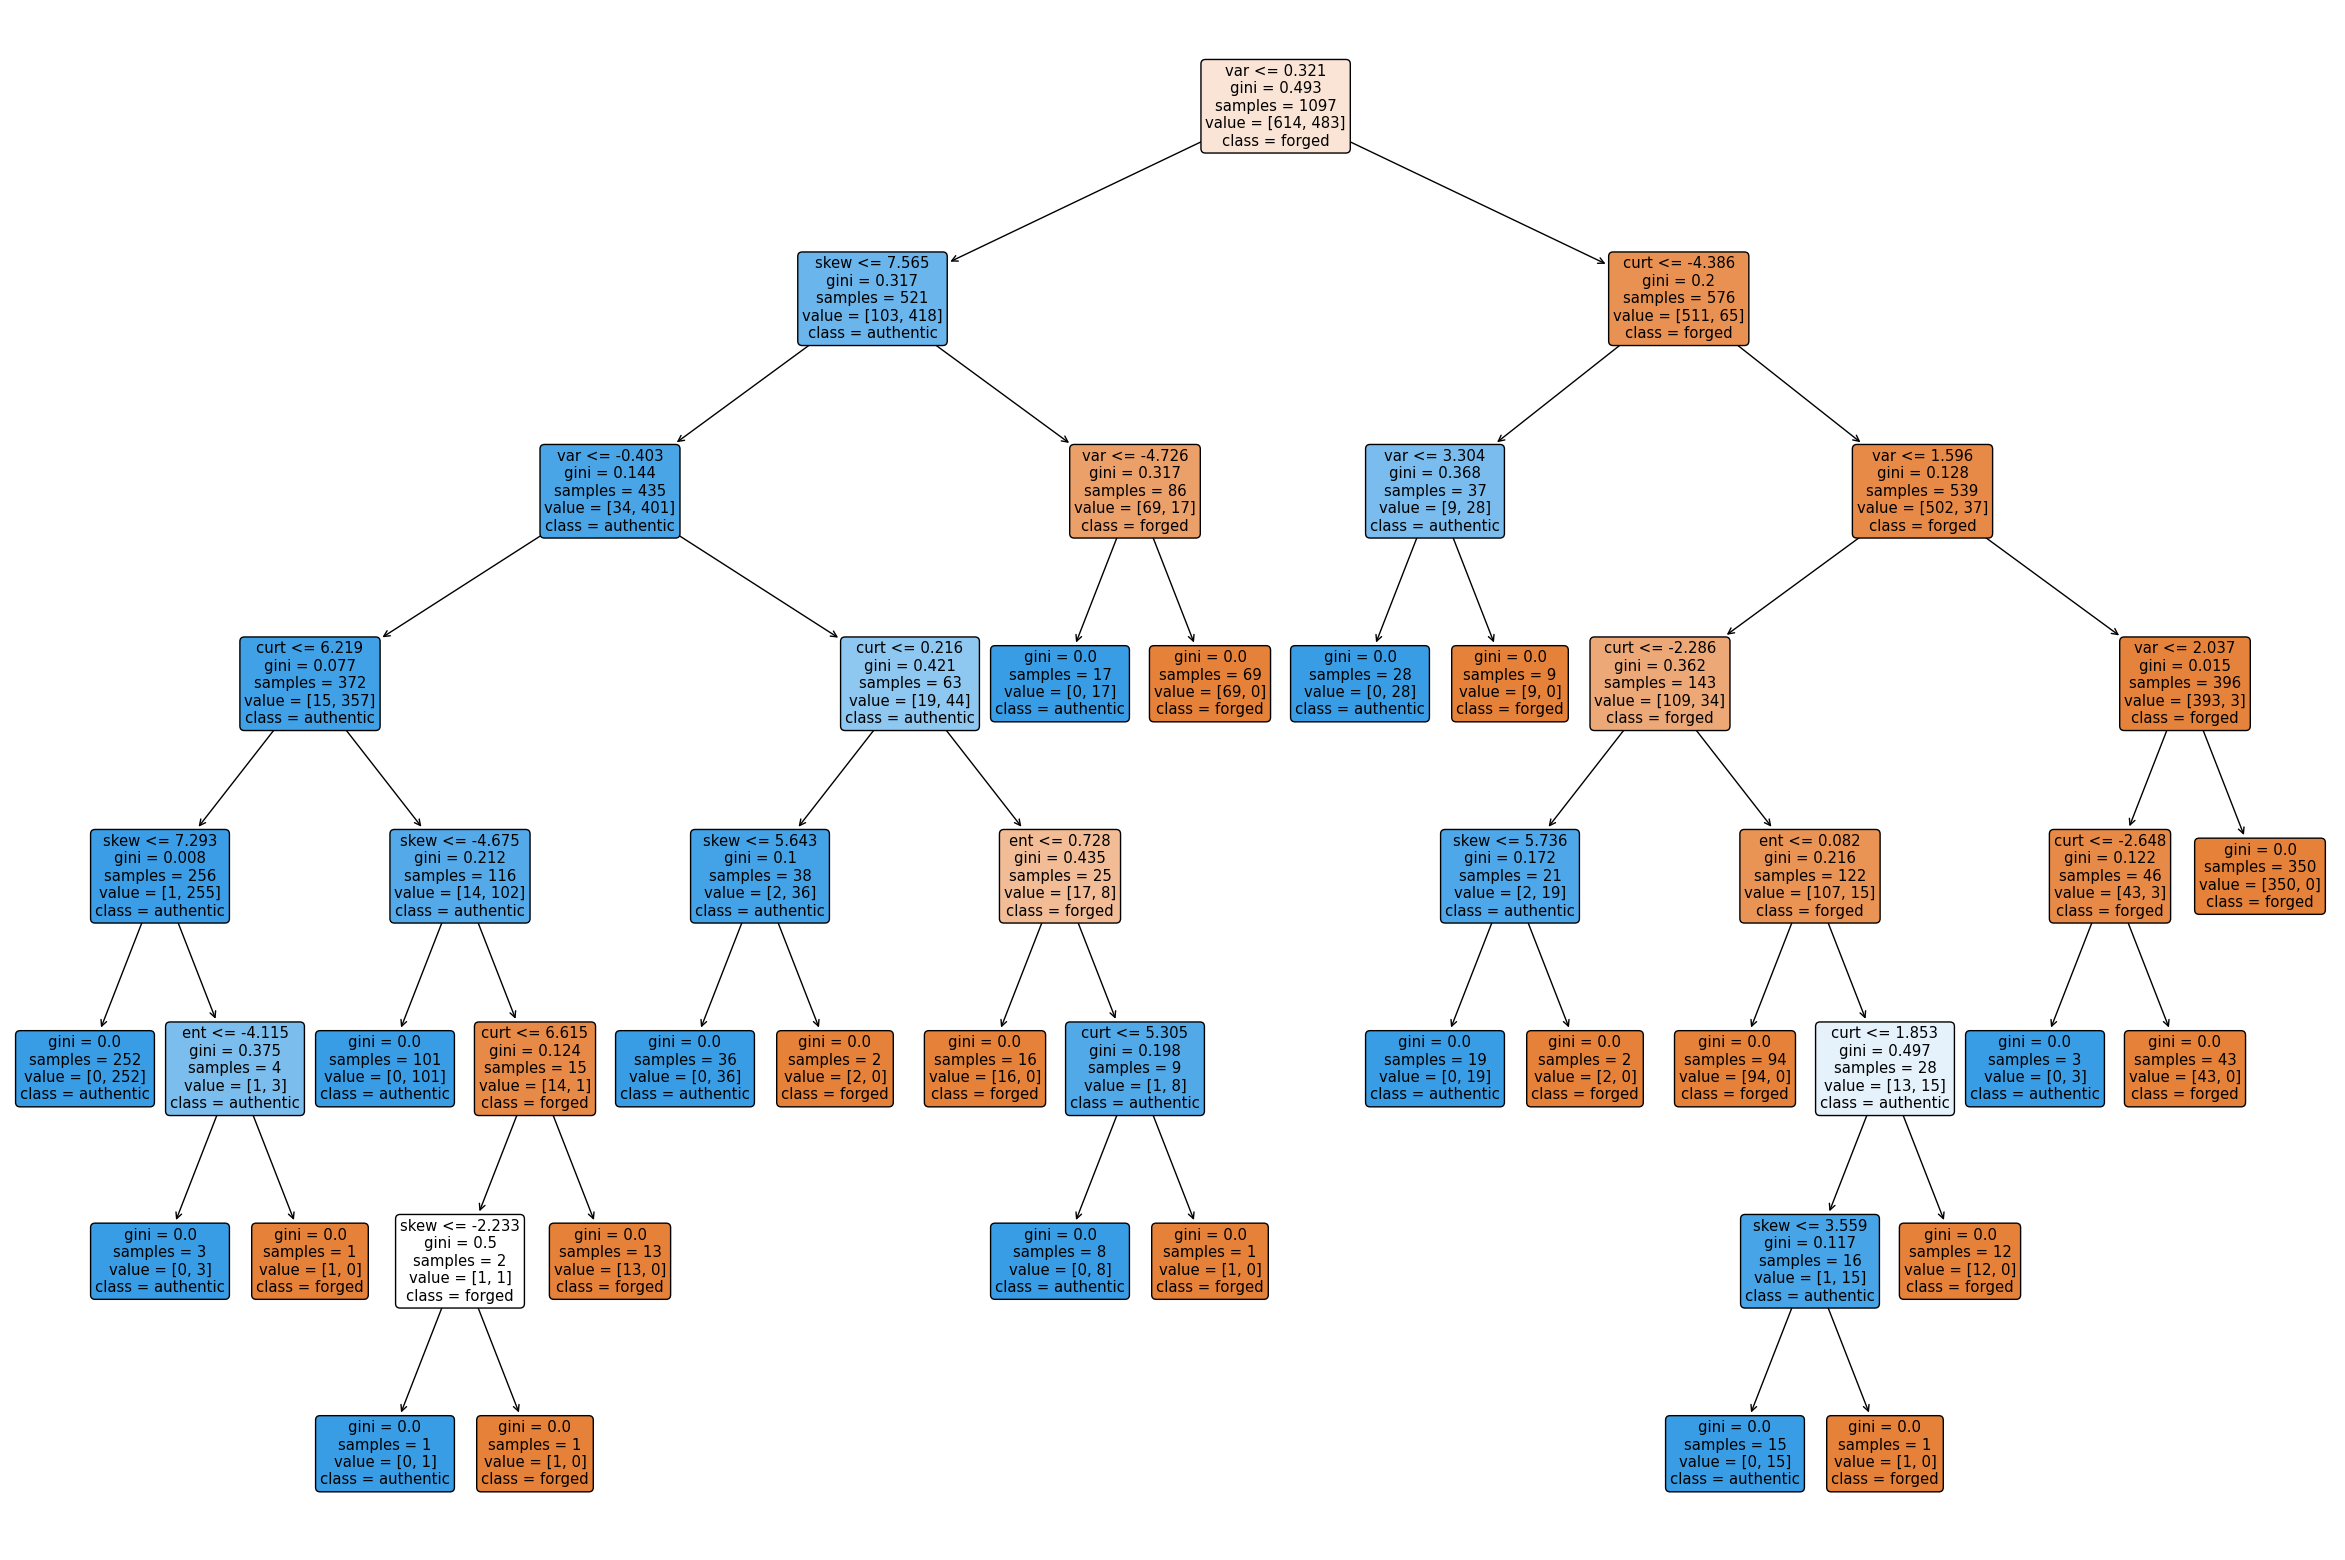

In [24]:
plotTree(cf)

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [19]:
data = pd.read_csv('bankAuth.txt',names=['variance','skewness','curtosis','entropy','label'])

In [20]:
data.describe()

,variance,skewness,curtosis,entropy,label
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   label     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [22]:
# your code here
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

In [25]:
# your code here
cf= DecisionTreeClassifier(criterion='gini', random_state=0)  
cf.fit(X_train, Y_train)  

Y_pred = cf.predict(X_test) 
accuracy_score(Y_test, Y_pred)

0.9818181818181818